In [3]:
# Importamos las librerias necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Cargamos los datasets
df_games_full = pd.read_csv("../data/processed/dataset_games_full.csv")
df_reviews = pd.read_csv("../data/processed/dataset_reviews.csv")
df_users = pd.read_csv("../data/processed/users.csv")

In [5]:
# Credibilidad de los usuarios
full_helpful_user = df_reviews.groupby("user_id")["helpful"].sum().reset_index() # Agrupamos por user_id y sumamos la columna helpful
full_helpful_user.rename(columns={"helpful": "total_helpful"}, inplace=True) # Renombramos la columna helpful a total_helpful
df_users = df_users.merge(full_helpful_user, on="user_id", how="left") # Unimos el dataframe df_users con el dataframe full_helpful_user por la columna user_id
df_users["total_helpful"] = df_users["total_helpful"].fillna(0) # Rellenamos los valores nulos de la columna total_helpful con 0
df_users["credibility"] = df_users["total_helpful"] / (df_users["reviews"] + 1) # Calculamos la credibilidad dividiendo la columna total_helpful entre la columna reviews + 1 para evitar divisiones por cero
print("La media de reviews por usuario es: ", df_users["reviews"].mean()) # Mostramos la media de reviews por usuario
df_trusted_users = df_users[df_users["reviews"] >= 3] # Filtrar usuarios con al menos 3 reseñas publicadas

# Mostrar resumen
print("Usuarios con al menos 3 reviews:")
display(df_trusted_users[["user_id", "reviews", "total_helpful", "credibility"]].sort_values("credibility", ascending=False).head())


La media de reviews por usuario es:  2.8767377246459964
Usuarios con al menos 3 reviews:


,user_id,reviews,total_helpful,credibility
3377614,626194,3,19736.0,4934.00
9214747,451002,3,16965.0,4241.25
6580022,3087416,4,19421.0,3884.20
12675724,2076702,3,14837.0,3709.25
8328546,6611547,3,14641.0,3660.25


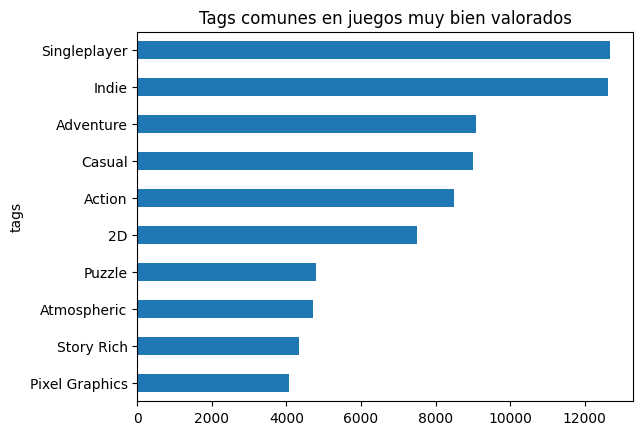

Juegos bien valorados con número de recomendaciones de usuarios confiables:


,title,positive_ratio,total_recomendations
23958,Team Fortress 2,93,195449.0
8686,The Witcher® 3: Wild Hunt,96,131624.0
10898,DARK SOULS™ III,94,131408.0
8928,Fallout 4,83,129724.0
9864,Tom Clancy's Rainbow Six® Siege,86,114490.0


In [7]:
# Que tipo de juego son exitosos según sus reseñas por usuarios confiables
df_highrated_games = df_games_full[df_games_full["positive_ratio"] > 80]
df_highrated_games["tags"].str.split(", ").explode().value_counts().head(10).plot(kind="barh", title="Tags comunes en juegos muy bien valorados")
plt.gca().invert_yaxis()
plt.show()
recommended_game = df_reviews[df_reviews["user_id"].isin(df_trusted_users["user_id"])]
# Aggregate total recommendations and good recommendations by app_id
total_recommendations = recommended_game.groupby("app_id")["is_recommended"].size().reset_index(name="total_recomendations")
good_recommendations = recommended_game[recommended_game["is_recommended"] == True].groupby("app_id").size().reset_index(name="good_recomendations")

# Merge the aggregated data back into the recommended_game DataFrame
df_highrated_games = df_highrated_games.merge(total_recommendations, on="app_id", how="left")
df_highrated_games = df_highrated_games.merge(good_recommendations, on="app_id", how="left")
# Modificamos los campos NaN a 0
df_highrated_games["total_recomendations"] = df_highrated_games["total_recomendations"].fillna(0)

print("Juegos bien valorados con número de recomendaciones de usuarios confiables:")
display(df_highrated_games[["title", "positive_ratio", "total_recomendations"]].sort_values("total_recomendations", ascending=False).head())


In [11]:
#ratio de recomendación 
df_highrated_games["recommendation_ratio"] = df_highrated_games["good_recomendations"] / df_highrated_games["total_recomendations"]
df_highrated_games.head(5) # Mostrar los primeros 10 juegos bien valorados

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,description,tags,total_recomendations,good_recomendations,recommendation_ratio
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True,Enter the dark underworld of Prince of Persia ...,"Action, Adventure, Parkour, Third Person, Grea...",1298.0,1104.0,0.850539
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True,NaN,NaN,0.0,NaN,NaN
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True,Monaco: What's Yours Is Mine is a single playe...,"Co-op, Stealth, Indie, Heist, Local Co-Op, Str...",4648.0,4147.0,0.892212
3,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True,Dungeon of the Endless is a Rogue-Like Dungeon...,"Roguelike, Strategy, Tower Defense, Pixel Grap...",4343.0,3831.0,0.882109
4,250180,METAL SLUG 3,2015-09-14,True,False,False,Very Positive,90,5579,7.99,7.99,0.0,True,"“METAL SLUG 3”, the masterpiece in SNK’s emble...","Arcade, Classic, Action, Co-op, Side Scroller,...",4168.0,3745.0,0.898512


In [17]:
# Crear un índice de éxito basado en recomendaciones y valoraciones
df_highrated_games["success_index"] = df_highrated_games["recommendation_ratio"] * (df_highrated_games["positive_ratio"]/100)

# Ordenar por índice de éxito y ver los mejores juegos
df_highrated_games[(df_highrated_games["user_reviews"] > 500)].sort_values("success_index", ascending=False).head(15)

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,description,tags,total_recomendations,good_recomendations,recommendation_ratio,success_index
1561,2206340,Aokana - Four Rhythms Across the Blue - EXTRA2,2022-12-16,True,False,False,Overwhelmingly Positive,100,530,24.99,24.99,0.0,True,Aokana - EXTRA2 is the official Misaki after s...,"Sports, Cute, Visual Novel, Romance, Casual, S...",332.0,332.0,1.000000,1.000000
19571,858940,Flowers -Le volume sur ete-,2018-07-26,True,False,False,Overwhelmingly Positive,99,929,19.99,19.99,0.0,True,Summer has arrived early to Saint Angraecum Ac...,"Visual Novel, Female Protagonist, LGBTQ+, Roma...",547.0,546.0,0.998172,0.988190
7631,1100140,Touhou Fuujinroku ~ Mountain of Faith.,2020-06-05,True,False,False,Overwhelmingly Positive,99,683,14.99,14.99,0.0,True,我が国には八百万の神々がいる 弾幕は八百万発程度では終わらない ノスタルジックでネイティブな...,"Indie, Action, Bullet Hell, Shoot Em Up, Great...",364.0,363.0,0.997253,0.987280
4530,1717770,The Upturned,2022-03-23,True,False,False,Overwhelmingly Positive,99,511,9.99,9.99,0.0,True,A frantic adventure. Welcome to the Upturned I...,"Physics, Comedy, Survival Horror, 3D Platforme...",248.0,247.0,0.995968,0.986008
5292,2070550,A Castle Full of Cats,2022-11-09,True,False,True,Overwhelmingly Positive,99,1271,2.99,2.99,0.0,True,A Castle Full of Cats is a catvania hidden obj...,"Cats, Hidden Object, Wholesome, Creature Colle...",434.0,432.0,0.995392,0.985438
1387,1171320,Frog Detective 3: Corruption at Cowboy County,2022-10-26,True,True,False,Overwhelmingly Positive,99,865,4.99,4.99,0.0,True,"You're a detective, and a frog, and it's time ...","Comedy, Funny, Short, Casual, Cute, Mystery, D...",410.0,408.0,0.995122,0.985171
1765,1307580,TOEM,2021-09-17,True,True,False,Overwhelmingly Positive,99,2321,19.99,19.99,0.0,True,Set off on a delightful expedition and use you...,"Cozy, Wholesome, Adventure, Puzzle, Exploratio...",1118.0,1112.0,0.994633,0.984687
24969,1586800,Lil Gator Game,2022-12-14,True,False,False,Overwhelmingly Positive,99,1952,19.99,19.99,0.0,True,"Embark on an adorable adventure, discover new ...","Casual, Cozy, Relaxing, Cute, Wholesome, Famil...",725.0,721.0,0.994483,0.984538
11265,1901370,Ib,2022-04-11,True,False,False,Overwhelmingly Positive,99,2073,12.99,12.99,0.0,True,A 2D exploration adventure game set in a creep...,"Horror, 2D, Female Protagonist, RPGMaker, Psyc...",746.0,741.0,0.993298,0.983365
465,1144400,Senren＊Banka,2020-02-14,True,False,False,Overwhelmingly Positive,99,11410,34.99,34.99,0.0,True,Senren＊Banka is a Japanese-style visual novel ...,"Visual Novel, Casual, Adventure, Dating Sim, A...",5861.0,5821.0,0.993175,0.983243
